# CNN for Dogs vs Cats.

For this project, I am using a large dataset of dogs and cats. I want to classify these. For this I label 'dog' with the label 1, and 'cat' with the label 0. From this I then make a CNN. Finally, I will apply transfer learning in this project to see what this does to the accuracy.

For this project I've used the following tutorial on kaggle: <br>
https://www.kaggle.com/code/shindeshubham85/a-friendly-introduction-to-cnns-in-keras

Importing the libraries

In [2]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import glob

## 1. Get the images

In [3]:
# let's look at any five files in the train folder
glob.glob("dogs-vs-cats/train/train/*.jpg")[:5]

['dogs-vs-cats/train/train\\cat.0.jpg',
 'dogs-vs-cats/train/train\\cat.1.jpg',
 'dogs-vs-cats/train/train\\cat.10.jpg',
 'dogs-vs-cats/train/train\\cat.100.jpg',
 'dogs-vs-cats/train/train\\cat.1000.jpg']

In [4]:
glob.glob("dogs-vs-cats/train/train/*.jpg")[-5:]

['dogs-vs-cats/train/train\\dog.9995.jpg',
 'dogs-vs-cats/train/train\\dog.9996.jpg',
 'dogs-vs-cats/train/train\\dog.9997.jpg',
 'dogs-vs-cats/train/train\\dog.9998.jpg',
 'dogs-vs-cats/train/train\\dog.9999.jpg']

The label is encoded in the filename itself- cat or dog! We need to extract that to be able to train the model.

We are collecting each filename, and the corresponding label in a pandas dataframe (needed later)

In [5]:
train_files = glob.glob("dogs-vs-cats/train/train/*.jpg")
train_labels = [i.strip('dogs-vs-cats/train/train/')[1:4] for i in train_files]
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
train_df.head()

,filename,class
0,dogs-vs-cats/train/train\cat.0.jpg,cat
1,dogs-vs-cats/train/train\cat.1.jpg,cat
2,dogs-vs-cats/train/train\cat.10.jpg,cat
3,dogs-vs-cats/train/train\cat.100.jpg,cat
4,dogs-vs-cats/train/train\cat.1000.jpg,cat


## 2. Look at them!
We now observe what the images look like. We'll look at four random images from the data.

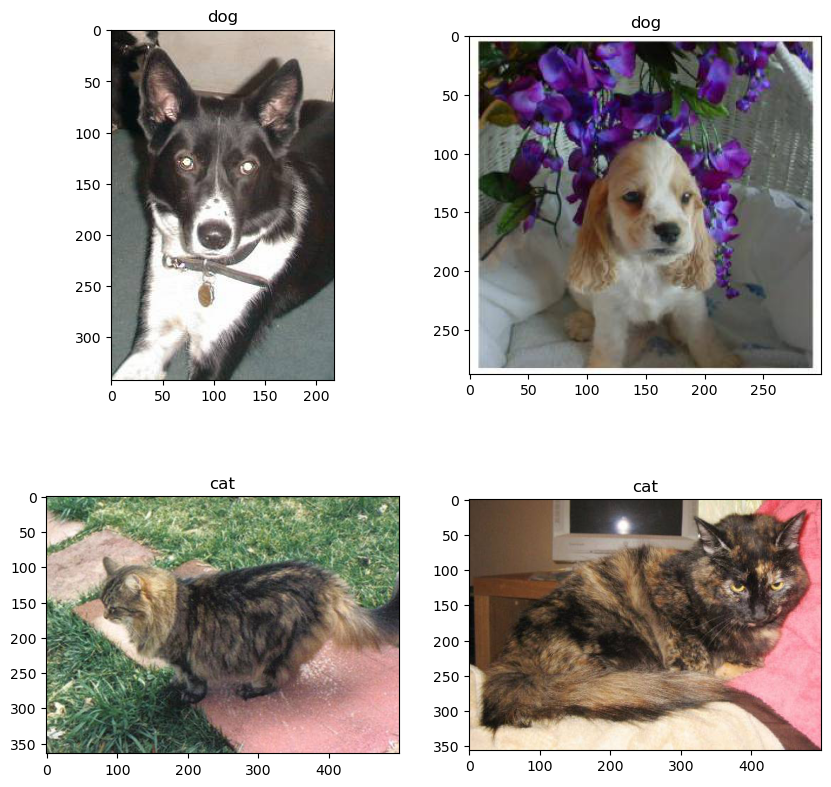

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(train_df.index)
    axs[i].imshow(Image.open(train_df['filename'][idx]))
    axs[i].set_title(train_df['class'][idx])

## 3. Release the Loader!

Step 1 is to set up an ImageDataGenerator from keras to create our training data loader. This involves defining the ImageDataGenerator instance and specifying the augmentation strategies.

Step 2 is to create a generator using the previously defined instance, which requires specifying the image file paths and labels. This generator will be passed to the model for training.

In pytorch, there are two main tools for handling data: torch.utils.data.Dataset and torch.utils.data.DataLoader. While there may be instances where a custom dataloader is necessary, the default options provided are generally sufficient for most use cases.

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=5, #: randomly rotate images within the range of 0 to 5 degrees.
    rescale=1./255, # : rescale the pixel values of each image to be between 0 and 1.
    horizontal_flip=True, #: randomly flip the images horizontally.
    shear_range=0.2, # : randomly apply a shear transformation to the images.
    zoom_range=0.2, # : randomly zoom into the images.
    validation_split=0.2) # : set aside 20% of the training data for validation.

# create a image data generator object. 
# all these are data augmentation parameters.

# now let's specify the image size to which each image will be resized to
img_height, img_width = 224, 224
batch_size = 64

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, #: the DataFrame containing the file paths and labels of the training data.
    target_size=(img_height, img_width), #: the size to which the images will be resized.
    batch_size=batch_size, #: the number of samples per gradient update during training.
    class_mode='categorical', #: the type of label arrays that will be returned (categorical for one-hot encoded labels).
    subset='training') # specifies that this generator will be used for training

# This generator will be used for validation
validation_generator = train_datagen.flow_from_dataframe(
    train_df, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

print("Class Indices:", train_generator.class_indices)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Class Indices: {'cat': 0, 'dog': 1}


## 4. Define A Model

We are going to define a series of Convolution Layers, and each convolution layer consists of a convolution operation followed by a max pool layer.


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential() # : creates a new sequential model.

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(img_width, img_height, 3)))
# : adds a convolutional layer to the model with 32 filters of size 3x3. 
# The input shape is set to the dimensions of the images being inputted into the model. 
# The activation function used is ReLU.
model.add(BatchNormalization())
# adds a batch normalization layer to the model. 
# This helps the model to converge faster and improve generalization.
model.add(MaxPooling2D(pool_size=(2, 2)))
# adds a max pooling layer to the model, which downsamples the input data along its spatial dimensions. 
# In this case, the pooling layer has a pool size of 2x2.
model.add(Dropout(0.25))
# : adds a dropout layer to the model. Dropout is a regularization technique that randomly
#  drops out a fraction of the units in the previous layer during training, to prevent overfitting.

# The next two blocks add two more convolutional blocks to the model with 64 and 128 filters, 
# respectively, followed by max pooling and dropout layers.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# convolutional block is complete. now on to defining the "head"

# first flatten the matrix to get a single array
model.add(Flatten())
# adding a dense hidden layer with 512 neurons and ReLU activation.
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# finally the output layer with neurons=number of classes and softmax activation
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

Let's visualize how our network looks like, and what the shapes of input and output at each layer.

The shapes of input and output can be useful for debugging. If there's a mismatch between output of one layer and input of next, model will throw up error.

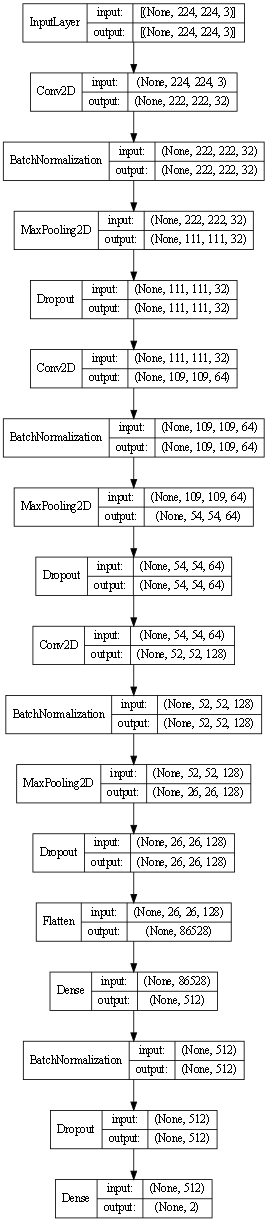

In [10]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [11]:
# compile the model while defining a loss, optimizer, and metrics to track, 
# and add callbacks if necessary
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [12]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/10
313/313 [==============================] - 585s 2s/step - loss: 0.7331 - accuracy: 0.6536 - val_loss: 0.4438 - val_accuracy: 0.9156
Epoch 2/10
313/313 [==============================] - 588s 2s/step - loss: 0.5332 - accuracy: 0.7297 - val_loss: 11.7354 - val_accuracy: 0.1384
Epoch 3/10
313/313 [==============================] - 589s 2s/step - loss: 0.4960 - accuracy: 0.7559 - val_loss: 0.3656 - val_accuracy: 0.8370
Epoch 4/10
313/313 [==============================] - 586s 2s/step - loss: 0.4515 - accuracy: 0.7865 - val_loss: 0.4501 - val_accuracy: 0.8034
Epoch 5/10
313/313 [==============================] - 569s 2s/step - loss: 0.4143 - accuracy: 0.8066 - val_loss: 0.6755 - val_accuracy: 0.6356
Epoch 6/10
313/313 [==============================] - 566s 2s/step - loss: 0.3848 - accuracy: 0.8274 - val_loss: 0.4925 - val_accuracy: 0.7742
Epoch 7/10
313/313 [==============================] - 554s 2s/step - loss: 0.3551 - accuracy: 0.8425 - val_loss: 0.3278 - val_accuracy: 0.857

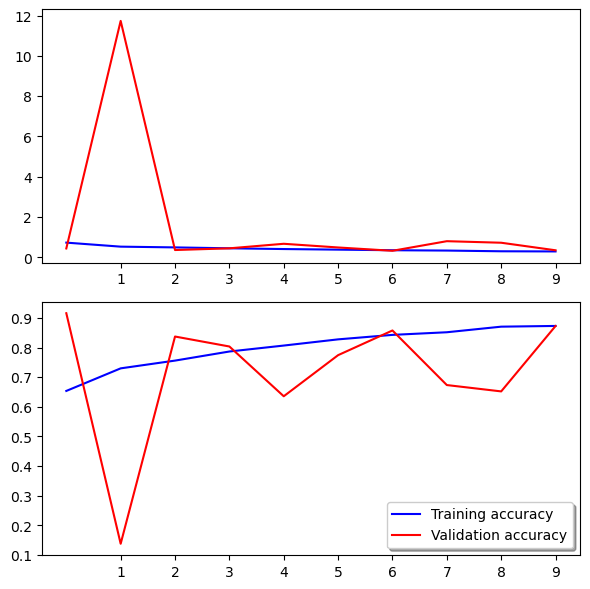

In [13]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()
plot_loss(history)

## 6. Get the Predictions

Now that the model is trained, let's check if the model is giving us good predictions, by trying it out on the test data.

In [14]:
test_files = glob.glob('dogs-vs-cats/test1/test1/*.jpg')
test_df = pd.DataFrame({'filename': test_files})
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


The next code block will generate 15 images from the test dataset and shows the predicted class for each image based on the provided model.

The function creates a 12 by 12-inch figure and then uses a for loop to iterate over the first 15 batches of images from the test_generator. For each batch, the model predicts the class of the first image, which is then displayed along with the image using plt.imshow(). The predicted class is displayed as the title of the image. The loop breaks after the first batch is processed

Finally, plt.tight_layout() is called to adjust the layout of the subplots, and plt.show() is called to display the plot. This function is useful to quickly check if the model is making accurate predictions on the test data.

2/2 [==============================] - 0s 165ms/step


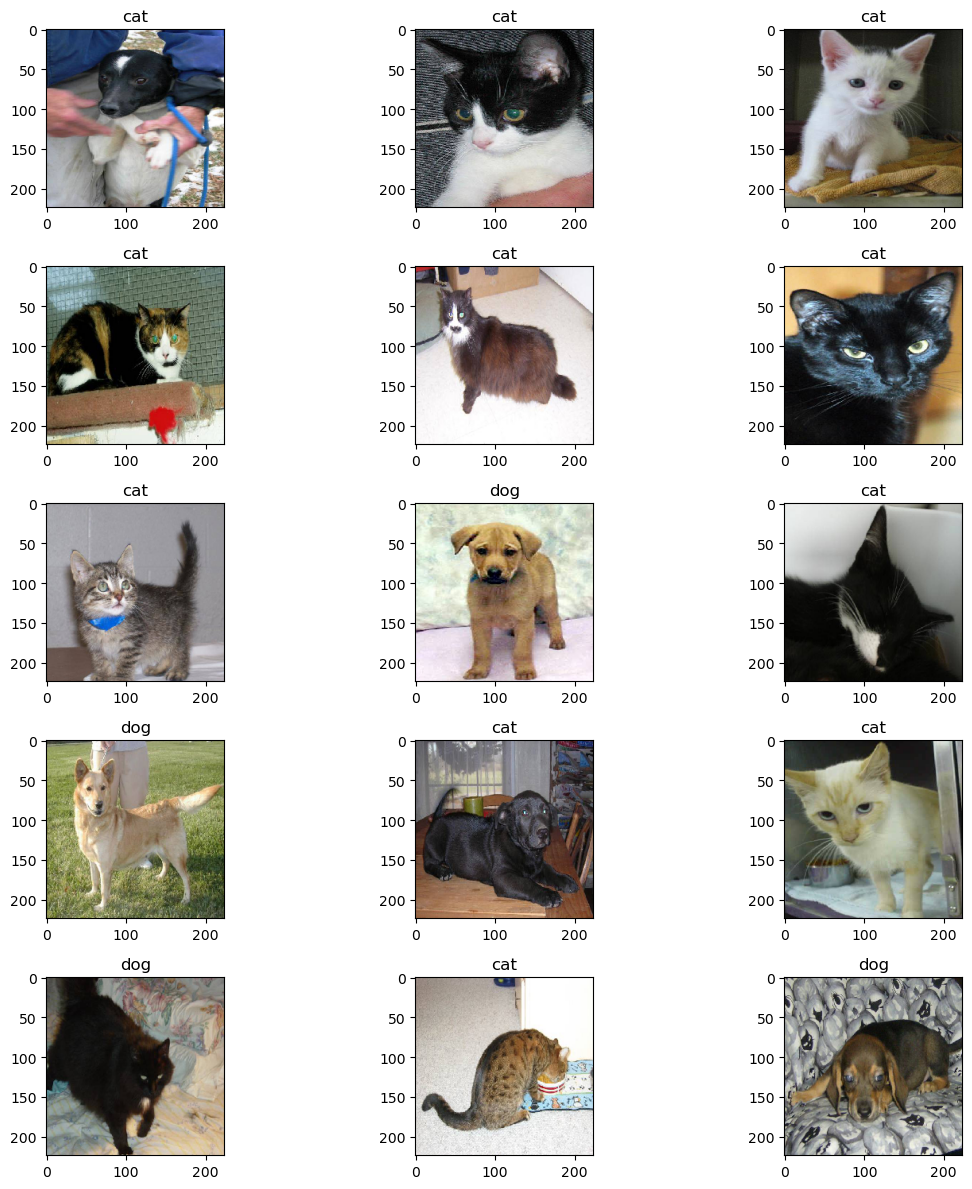

In [15]:
def visualize_predictions(test_generator, model):
    plt.figure(figsize=(12, 12))
    for i in range(0, 15):
        plt.subplot(5, 3, i+1)
        for X_batch in test_generator:
            prediction = model.predict(X_batch)[0]
            image = X_batch[0]
            plt.imshow(image)
            plt.title('cat' if np.argmax(prediction)==0 else "dog")
            break
    plt.tight_layout()
    plt.show()
visualize_predictions(test_generator, model)

### Result
The accuracy of the model is 87%. You can see in the pictures shown above that not all images are correctly labeled.

# Tranfer Learning

Transfer learning is a technique in deep learning where a pre-trained model on a large dataset is used as a starting point to train a new model on a smaller dataset with a similar problem. Instead of starting from scratch, transfer learning allows us to use the knowledge learned from the pre-trained model to improve the performance of the new model. This is particularly useful when there is not enough data available to train a model from scratch. Popular pre-trained models include ResNet, VGG, and Inception, which have been trained on massive datasets like ImageNet. By using transfer learning, we can avoid the time-consuming and computationally expensive task of training a model from scratch and achieve better results with less data.

In [21]:
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import Input
from tensorflow.keras.models import Model

# ResNet50 is our "backbone" of sorts, a CNN architecture 
# pretrained on the imagenet dataset
# we are only taking the CNN portion of it (include_top = False)
# and dropping the dense layer, we'll initialize a dense network of our own

basemodel = Xception(include_top = False, 
                   weights = 'imagenet',
                  input_shape=(img_height, img_width, 3))

basemodel.trainable = False

# use the output of the baseModel to create a "head"
headModel = basemodel.output
headModel = MaxPooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.8)(headModel)
# headModel = Dense(32, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# at the end, we'll have two neurons, for two of the classes

# we're "disabling" the backbone, and only training the head for this task
# we're assuming that the backbone is already sufficiently trained to generate
# features from images like ours.
# we can also "disable" all CNN layers except last 4

# create a model object
model = Model(inputs=basemodel.input, outputs=headModel)

83683744/83683744 [==============================] - 11s 0us/step


In [23]:
# plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

## Experiment Tracking

In the previous case, we had to manually plot the losses and metrics after the model training was completed using matplotlib. However, there are tools available that allow us to monitor the training progress in real-time. These tools also keep track of system metrics such as GPU usage and can manage multiple experiments and hyperparameters. One such tool is wandb.ai, which allows you to track your model's progress even on your phone as it runs in the background.

In [29]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Warmtebron/.netrc


True

In [32]:
import wandb
from wandb.keras import WandbCallback

if use_wandb:
    wandb.init(project="keras_cats_and_dogs", config={"batch_size": batch_size})

wandb: Currently logged in as: heather-diemen (warmtebron). Use `wandb login --relogin` to force relogin


In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

In [34]:
epochs=5
callbacks=[EarlyStopping(monitor='loss', patience=2), ]
if use_wandb: callbacks.append(WandbCallback())

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
C:\Users\Warmtebron\AppData\Local\Temp\ipykernel_19372\653423426.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9668

INFO:tensorflow:Assets written to: c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best)... Done. 0.2s


313/313 [==============================] - 646s 2s/step - loss: 0.1083 - accuracy: 0.9668 - val_loss: 0.1079 - val_accuracy: 0.9656
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9751

INFO:tensorflow:Assets written to: c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best)... Done. 0.2s


313/313 [==============================] - 629s 2s/step - loss: 0.0790 - accuracy: 0.9751 - val_loss: 0.0683 - val_accuracy: 0.9746
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9775

INFO:tensorflow:Assets written to: c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Warmtebron\Documents\School\AI_Advanced\Core 3\wandb\run-20230306_140953-belylcz3\files\model-best)... Done. 0.2s


313/313 [==============================] - 656s 2s/step - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.0574 - val_accuracy: 0.9806
Epoch 4/5
313/313 [==============================] - 648s 2s/step - loss: 0.0595 - accuracy: 0.9793 - val_loss: 0.0831 - val_accuracy: 0.9732
Epoch 5/5
313/313 [==============================] - 629s 2s/step - loss: 0.0574 - accuracy: 0.9794 - val_loss: 0.0794 - val_accuracy: 0.9718


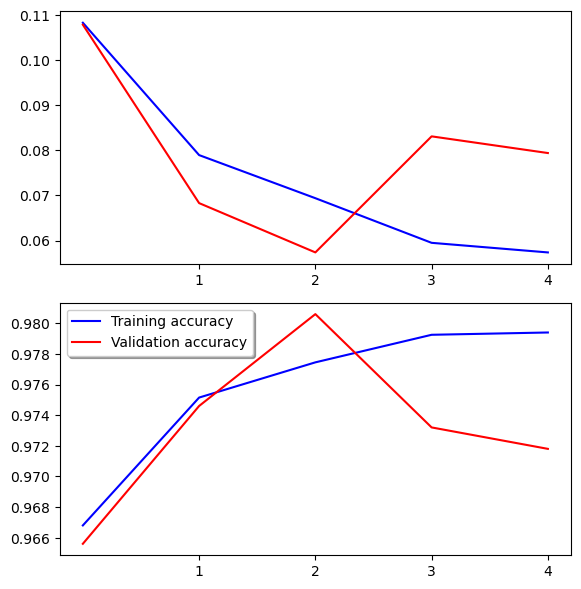

In [35]:
plot_loss(history)

2/2 [==============================] - 2s 830ms/step


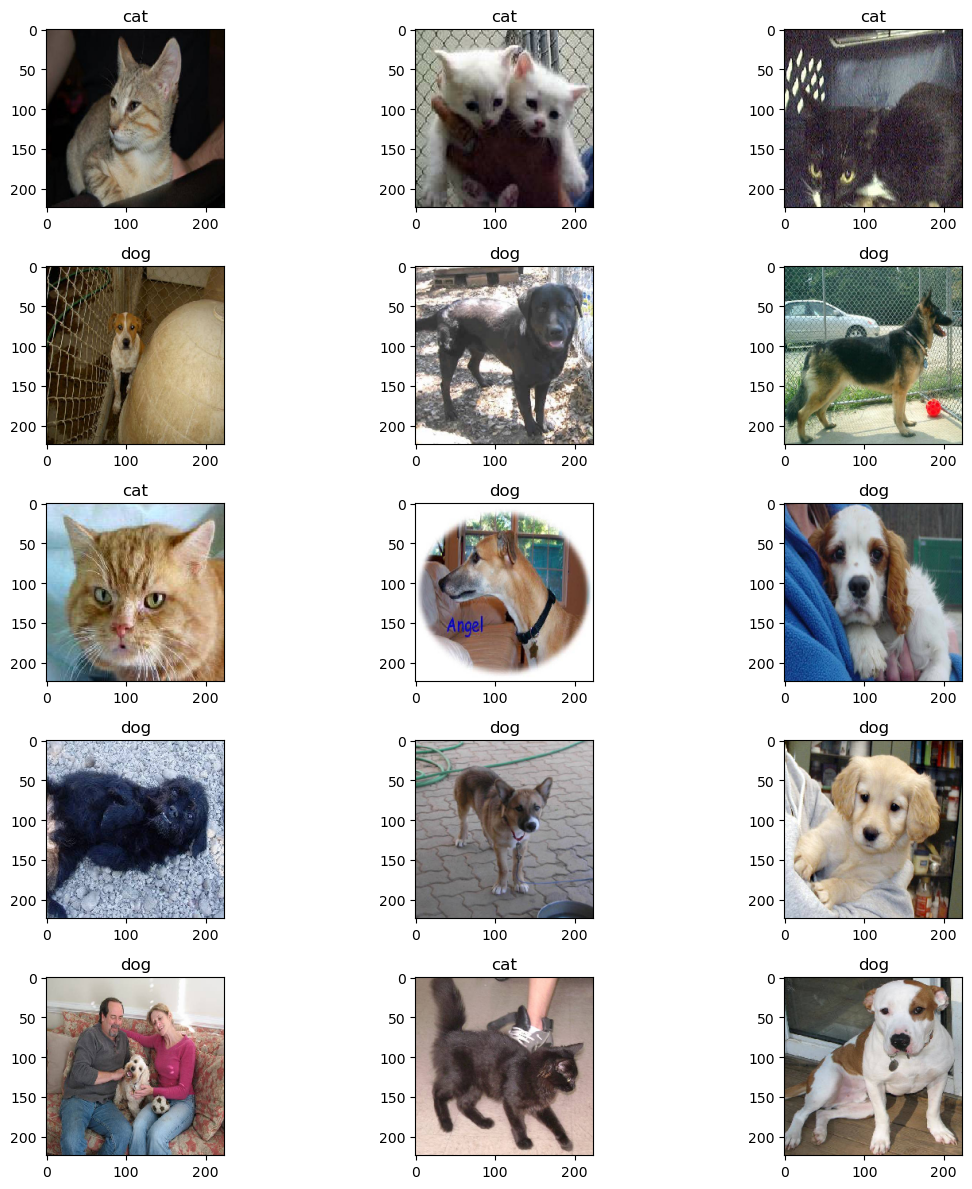

In [36]:
visualize_predictions(test_generator, model)

# Conclusion

The custom model we defined earlier achieved a validation accuracy of 85% after 10 epochs. However, by using a pre-trained model, we were able to achieve a validation accuracy of 98% after just one epoch. This demonstrates the significant performance boost that can be achieved with minimal training efforts by leveraging the pre-existing knowledge of the pre-trained model.